# Plotting and analyzing the results

## Table of contents
<a name="toc"></a>
1. [Importing needed libraries](#import)
2. [Overview of required files](#required_files)
3. [Plotting the results](#plotting)\
   3.1. [Energy vs time](#ene_time)\
   3.2. [Average partial density of states](#ave_pdos)\
   3.3. [NAC map](#nac_map)\
   3.4. [NAC distribution](#nac_dist)\
   3.5. [Influence spectrum](#inf_spec)
   
### A. Learning objectives

* To be able to plot the average partial density of states
* To be able to plot the computed excited states energies vs time
* To be able to plot the NAC map
* To be able to plot and analyze NAMD results
* To be able to compute and plot the influence spectrum

### B. Use cases


* [Plotting the results](#plotting)


### C. Functions

- `libra_py`
  - `data_stat`
    - [`cmat_distrib`](#nac_dist)
  - `influence_spectrum`
    - [`recipe1`](#inf_spec)
  - `units`
    - `au2ev`

## 1. Importing needed libraries <a name="import"></a>
[Back to TOC](#toc)

Since the data are stored in sparse format using `scipy.sparse` library, we need to load this library so that we can read the data. Import `numpy`, `scipy.sparse`, `CP2K_methods`, `data_stat`, `units`, and `step2_many_body` modules. `glob` library will be needed to find specific types of files.

In [4]:
import os
import glob
import h5py
import numpy as np
import scipy.sparse as sp
import matplotlib.pyplot as plt
from liblibra_core import *
from libra_py import units, data_stat, influence_spectrum
import libra_py.packages.cp2k.methods as CP2K_methods

## 2. Overview of required files <a name="required_files"></a>
[Back to TOC](#toc)

All of the pdos files are stored in this folder:

* `../../7_step2_cp2k/2_xTB/2_hpc/all_pdosfiles`

All the logfiles containing the excitation analysis data are stored in this folder:

* `../../7_step2_cp2k/2_xTB/2_hpc/all_logfiles`

All of the time-overlaps and nonadiabatic coupling matrices are stored in the cuurent directory and this folder:

* `res-sd-xTB`

## 3. Plotting the results <a name="plotting"></a>
[Back to TOC](#toc)


### 3.1. Energy vs time <a name="ene_time"></a>

Here, we will plot the energies of the many-body and single-particle excitation bases

<IPython.core.display.Javascript object>


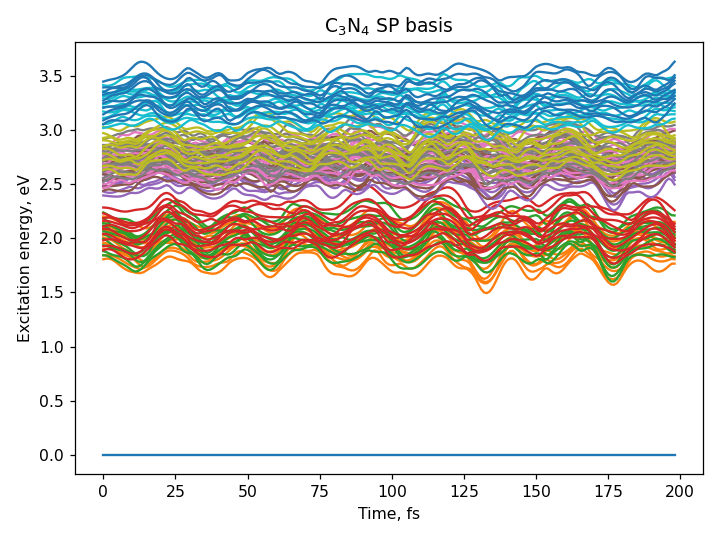

In [2]:
%matplotlib notebook
titles = ['SP basis']
plt.figure()
basis = 'sd'
#energy_files = glob.glob(F'res-mb-sd-DFT/Hvib_{basis}*re*')
#energy_files = data_io.sort_hvib_file_names(energy_files)
#print('Sorted energy files are:', energy_files)
dt = 1.0 # fs
energies = []
for step in range(1500,1699):
    file = F'res-sd-xTB/Hvib_{basis}_{step}_re.npz'
    energies.append(np.diag(sp.load_npz(file).todense().real))
energies = np.array(energies)*units.au2ev
md_time = np.arange(0,energies.shape[0]*dt,dt)
for i in range(energies.shape[1]):
    plt.plot(md_time, energies[:,i]-energies[:,0])

plt.title('C$_3$N$_4$ SP basis')
plt.ylabel('Excitation energy, eV')
plt.xlabel('Time, fs')
plt.tight_layout()

### 3.2. Average density of states <a name="ave_pdos"></a>
[Back to TOC](#toc)

In this section, we will plot the average partial density of states (pDOS) over the MD trajectory. There are two ways to take the average of the pDOS:

1- Average all the pDOS files and then convolve the average pDOS for each element.
2- Convolve the pDOS files and then take the average for each element.

We choose the first one due to two reasons. First, the computational cost is much lower and we only need one convolution. Second is that averaging over the grid points (using the method 2) is dependent on the number of grid points we use for convolution which again adds to the complexity of the procedure. 

Here, we will use normalized Gaussian function for weighting the pDOS values and summing them.

$$f(x)=\frac{1}{\sigma\sqrt{2\pi}}\exp(-\frac{(x-\mu)^2}{2\sigma^2})$$

This function is defined in the `CP2K_methods.gaussian_function`.

Now, we plot the pDOS for all of the angular momentum components of each atom. This is done by using the `orbital_cols`. In fact, the `orbital_cols` is related to `orbitals`. For example, for `s` orbital, we consider the 3rd index and for `p` orbital, we sum the columns from 4 to 6 (`range(4,7)`). Here we want to show how the code works and how the you can modify that based on your project. In the next section, we will show the pDOS only for atoms and sum all the components in each row of the pdos file. Other parameters are as follows:

`atoms`: The atoms names and numbers as appear in the `pdos` files which will be used in convolution, labeling and plotting. The atoms order should be exactly the same as appear in the `.pdos` files. For example, the `*k1*.pdos` files contain the pDOS data for `C` atom and `*k2*.pdos` files contain the data for the `N` atom. Therefore, we set `"atoms": [[1,2] , ['C', 'N']]`.

`npoints`: The number of grid points for making the Gaussian functions. Note that, this value should be more than the number of states in the `.pdos` files.

`sigma`: The standard deviation in eV.

`shift`: This value shifts the minimum and maximum energy found in the `pdos_ave` and will extend the boundaries from both sides by `shift`eV.

Finally, we will plot the total density of states. We manually set the HOMO energy level to zero.

<IPython.core.display.Javascript object>


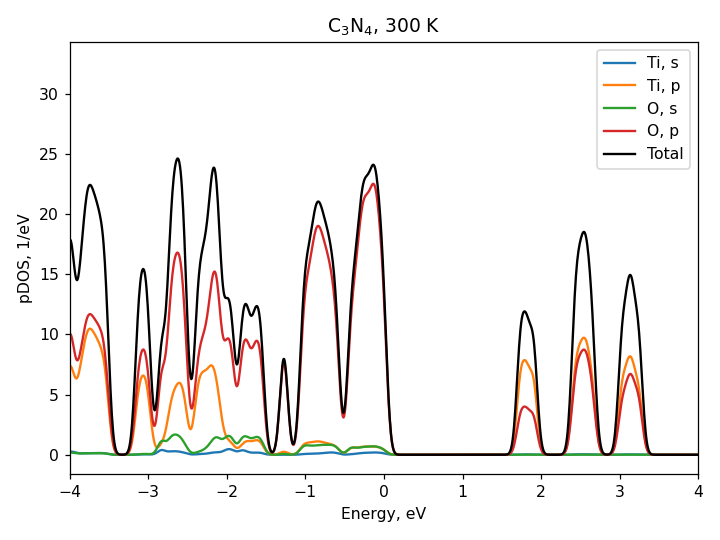

In [6]:
%matplotlib notebook
params = {"path_to_all_pdos": os.getcwd()+'/../../7_step2_cp2k/2_xTB/2_hpc/all_pdosfiles', "atoms": [[1,2] , ['Ti', 'O']],
          "orbitals_cols": [[3], range(4,7), range(7,12), range(12,19)], "orbitals":  ['s','p','d','f'],
          "npoints": 4000, "sigma": 0.05, "shift": 2.0}
ave_energy_grid, homo_energy, ave_pdos_convolved, pdos_labels, ave_pdos_convolved_total = CP2K_methods.pdos(params)
for i in range(len(pdos_labels)):
    pdos_label = pdos_labels[i]
    plt.plot(ave_energy_grid-homo_energy, ave_pdos_convolved[i], label=pdos_label)
plt.plot(ave_energy_grid-homo_energy, ave_pdos_convolved_total, color='black', label='Total')
plt.legend()
plt.xlim(-4,4)
plt.ylabel('pDOS, 1/eV')
plt.xlabel('Energy, eV')
plt.title('C$_3$N$_4$, 300 K')
plt.tight_layout()

### 3.3. NAC map <a name="nac_map"></a>
[Back to TOC](#toc)

One way of visualizing the NAC values is to plot the average NAC matrix using `plt.imshow`.

<IPython.core.display.Javascript object>


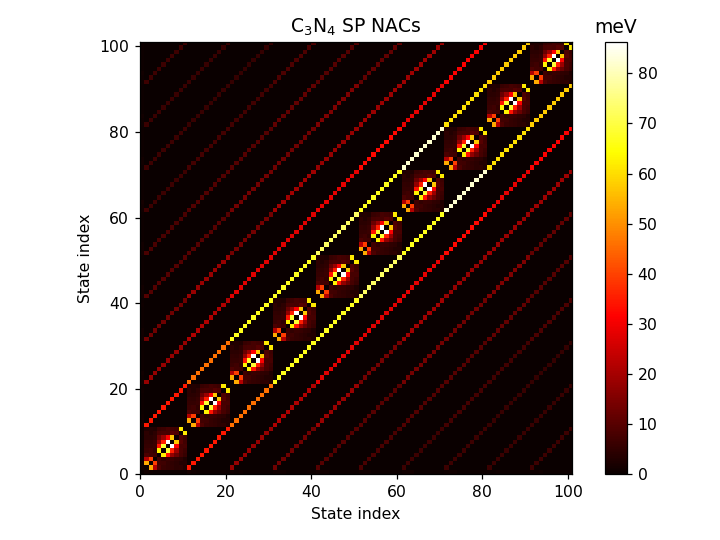

In [7]:
%matplotlib notebook
plt.figure()
basis = 'sd'
nac_files = glob.glob(F'res-sd-xTB/Hvib_{basis}*im*')
for c, nac_file in enumerate(nac_files):
    nac_mat = sp.load_npz(nac_file).todense().real
    if c==0:
        nac_ave = np.zeros(nac_mat.shape)
    nac_ave += np.abs(nac_mat)
nac_ave *= 1000*units.au2ev/c
nstates = nac_ave.shape[0]
plt.imshow(np.flipud(nac_ave), cmap='hot', extent=(0,nstates,0,nstates))#, vmin=0, vmax=100)
plt.xlabel('State index')
plt.ylabel('State index')
colorbar = plt.colorbar()
colorbar.ax.set_title('meV')
# plt.clim(vmin=0, vmax=90)
plt.title(F'C$_3$N$_4$ SP NACs')
plt.tight_layout()

### 3.4. NAC distribution <a name="nac_dist"></a>
[Back to TOC](#toc)

One of the intuitive ways to visualize the NACs is to plot the distribution of the NACs. Here we plot them for only SP excited states. A smoother distribution plot is obtained if more steps are involved.

<IPython.core.display.Javascript object>


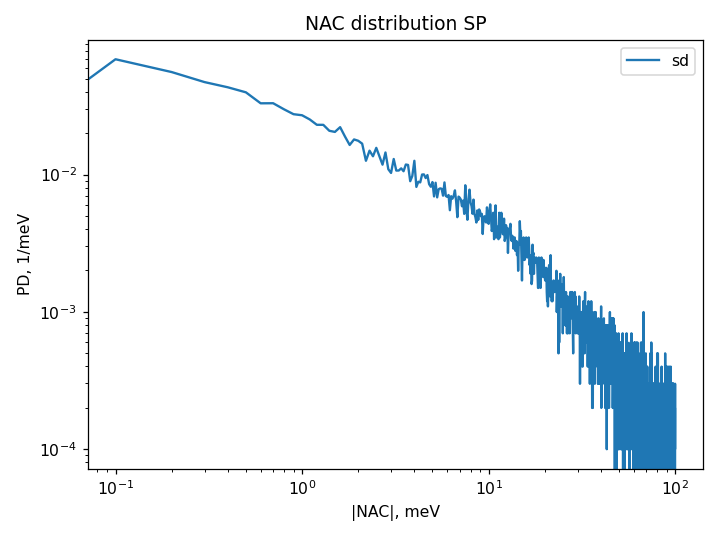

In [9]:
%matplotlib notebook
nac = []
nac_files = glob.glob(F'res-sd-xTB/Hvib_sd*im*')
for nac_file in nac_files:
    hvib = sp.load_npz(nac_file)
    hvib_dense = hvib.todense().real
    for i in range(hvib.shape[0]):
        for j in range(hvib.shape[0]):
            if j != i:
                nac_ij = np.abs(hvib_dense[i,j])* 1000.0 * units.au2ev
                x_mb = MATRIX(1,1)
                x_mb.set(0, 0, nac_ij )
                nac.append( x_mb )
bin_supp, dens, cum = data_stat.cmat_distrib( nac, 0, 0, 0, 0, 100, 0.1)
plt.plot( bin_supp, dens, label=basis)
plt.xlabel('|NAC|, meV')
plt.ylabel('PD, 1/meV')
plt.title('NAC distribution SP')
plt.legend()
plt.xscale('log')
plt.yscale('log')
plt.tight_layout()
# plt.savefig('nac_dist_1.jpg', dpi=600)

### 3.5. Influence spectrum <a name="inf_spec"></a>
[Back to TOC](#toc)


In order to compute the influence spectrum for the energy gap fluctuations between two states, `i` and `j`. The parameters that need to be passed to the function `influence_spectrum.recipe1` are as follows:

`data`: A list of `MATRIX(ndof, 1)` objects i.e. a sequence of real-valued ndof-dimensional vectors

`dt`: Time step in fs units
    
`wspan`: The window of frequencies for the Fourier transform with units cm$^{-1}$

`dw`: The grid points spacing in the frequency domain with units of cm$^{-1}$

`do_output`: Whether we print out the data the results into files

`acf_filename`: The name of the file where to print the ACF
    
`spectrum_filename`: The name of the file where to print the spectrum 

`do_center`: A flag controlling whether to center data (=`True`) or not (=`False`). Centering means we subtract the average value (over all the data points) from all the data points - this way, we convert values into their fluctuations 

`acf_type`: selector of the convention to to compute ACF:
```
   * 0 : the chemist convention,  (1/(N-h)) Sum_{t=1,N-h} (Y[t]*Y[t+h]) [ default ]
   * 1 : the statistician convention, (1/N) Sum_{t=1,N-h} (Y[t]*Y[t+h])
```

`data_type`: What is the format of the data?
```
        * 0 : list of MATRIX(ndof, 1) [ default ]
        * 1 : list of VECTOR
```

The `recipe1` function returns a tuple of (T, norm_acf, raw_acf, W, J, J2), where:

`T`: List with time axis in `fs` units

`norm_acf`: List with normalized ACF

`raw_acf`: List with un-normalized ACF

`W`: List with frequencies axis with units $cm^{-1}$

`J`: List with amplitudes of Fourier transform

`J2`: List with values of $(1/2\pi)|J|^2$

Select two states of interest to compute the influence spectrum for their energy gap fluctuations. Here we comute that for the ground state, `i=0`, and the first excited state, `j=1`.

In [10]:
# For computing influence spectra
params_inf_cpec = {"dt": 1.0, "wspan": 4000.0, "dw": 1.0, "do_output": False,
          "do_center": True, "acf_type": 1, "data_type": 0}

# Selecting the two states we want to compute the influence spectra for
i = 0; j = 1
# ========== Computing the autocorrelation function and the influence spectra
data_ij = []
for step in range(energies.shape[0]):
    x = MATRIX(1,1)
    if i<j:
        gap = energies[step,j]-energies[step,i]
    else:
        gap = energies[step,i]-energies[step,j]
    x.set(0,0, gap)
    data_ij.append(x)
Tij, ACFij, uACFij, Wij, Jij, J2ij = influence_spectrum.recipe1(data_ij, params_inf_cpec)


Now, we plot the data:

<IPython.core.display.Javascript object>


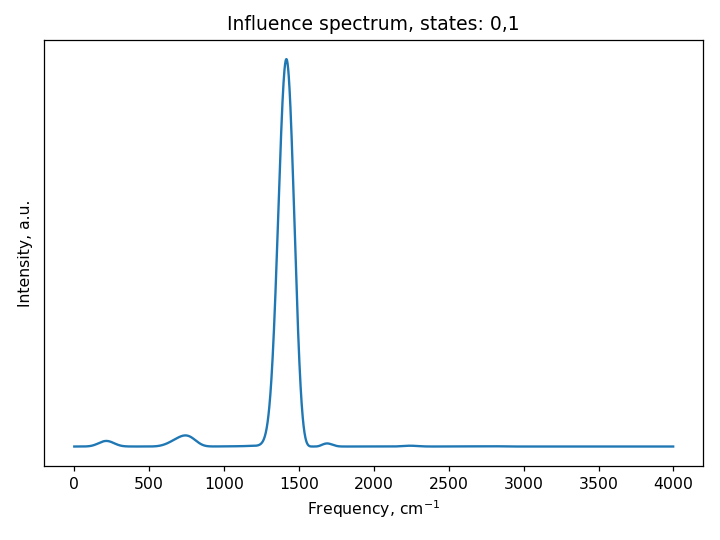

In [11]:
%matplotlib notebook
plt.plot(Wij, J2ij)
plt.xlabel('Frequency, cm$^{-1}$')
plt.ylabel('Intensity, a.u.')
plt.yticks([])
plt.title(F'Influence spectrum, states: {i},{j}')
plt.tight_layout()